## <center> The effect of the economic, social and cultural status on Uruguayan student’s probability of dropping out. A survival analysis application with interval-censoring.<center> 
<center> Maia Brenner. <center>
 <center>   Statistical Modeling and Inference <center>
  <center>  December 2018 <center>
    
    
    
   ** *Use R Kernel to run the code.** 
   
   ** *The data included in this project was shared for this academic project and should be treated as confidencial **
    

# Motivation

The aim of this project is to study more in depth a set of statistical methods used to investigate the time it takes for an event of interest to occurre. In particular, I will apply different methods and models to a real dataset where the time to the event cannot be easily meassured in a continuos metric.

The dataset, which from now on I will refer to as PISA-L, is a dataset which containes information of more than 2000 uruguayan students who took the international PISA test in 2009 (at the age of 15) and were surveyed 5 years later (2014). On the survey they were asked about their student activity on each of the past years. In particular, I will be interested in studying the dropout phenomenon and will focus on the questions which target that topic. Students were asked wether they were enrolled in an educational institution or not on the past years and whether they abandoned their studies on that academic year or not. If they had abandoned they were asked on which month they did so.
  
With this information we can define the "dropout" event as the event of not having attended classes, nor done exames for at least one year (no matter in which educational level the student was) and not accounting for the fact that the student could have restarted studying years later. We can messure the time-to-event in months if we considered the dropout date as the month in which he/she stop attending clases or we can define the time-to-event in years as being the dropout date the first year in which the student hasn't been enrolled in an academic institution. In other words we can think that the dropout event takes place in a specific day and even hour and minute of the day (the event unfolds in continuos time). However, our information about the event ocurrence is restricted to discrete-time intervals (months or years). 
  
The project will include a theoretical discussion as well as practical examples of the different methods that could be used with this type of dataset. The outline of the project is the following:
  
__1. Why are special statictical methods needed to studying event occurrence?__

      
 __2. Differences between parametric and semi-parametric models.__

  
__3. Differences between estimating time as a continuos or discrete variable. (Efron, Breslow, Complementary Log Log and Random Substraction)__

      
__4 .Trying different methods to estimate the effect of the socioeconomic cultural level on the probability of dropping out of school .__
  


##  __1.1 Why are special statistical methods needed for studying event occurrence?__

A nearly universal feature of survival data is censoring which means that for certain subjects we do not know the exact time of event.

The most common type of censoring is the so called **right censoring** which can occure because a subject leaves the study before an event occurs, or the study ends before the event has occurred. For example, in the PISA-L dataset in which the event is stop studying, we have right-censoring as there are students who did not stop studying before the study finished but they may do so after that period. Moreover, **left censoring** is when the event of interest has already occurred before enrollment. This is not that common to encountered due to study design. 

In addition to right censoring and left censoring some authors define **interval-censoring** to the cases in which the time when the event of interest occurs is not directly observed but is known to take place within some time interval. This is very common in this kind of educational research were events can be observed in a large time metric such as a year,
quarter, or month.

In addition to this clasification of censoring we can separate censoring into different cases which are **informative censoring** and **independent censoring**.

Informative censoring means that the censoring distribution may depend on the unknown parameters in the model. On the other hand independent censoring means that, conditional on covariates at each duration, the censored items are “representative” of those under observation at the same time. In other words, items may not be censored (withdrawn) because they have a higher or lower risk than the average, given the covariates.

In the PISA-L dataset we can observe that of the 2608 students who took the PISA test in 2009 and were surveyed in 2014, 44% can be considered as censored given that they had not dropout (experienced the "death" event) in the period. However, conditional on covariates, these censored observations are "representative" of those under observations. It is common in this type of longitudinal studies to have "missing" data of students who could not be find to surveyed 5 years later and in particular the "missing students" could have higher probability of dropping out. However, the 2608 student sample was created in such precise way in order not to account for this type of "missing data" and therefore we can assume that there is no informative censoring. More information on the data contruction can be find in Cardozo,S. 2014.

Finally, our dataset could be thought to present **left truncation** which occurs when the subjects have been at risk before entering the study. In our case, the students are a representative national sample of uruguayan students who took the PISA test in 2009, which does not mean that is representative of the entire uruguayan cohort since at the age of 15 there could be some students who had already dropped out of school. Therefore, if we considered t=0 as the start of observation time and not as the start of schooling we do not account for "left truncation".

# Data Exploration

In [5]:
library(foreign)
library(haven)
library(corrplot)
library(tidyverse)
library(dplyr)
library(survival)
library(readxl)
library(ggplot2)
library(survminer)
library(Hmisc)

##Change the path to import the dataset
df_completa<-read_excel("./Final_Project_Folder/df_completa.xlsx") 

##The description of the variables can be find in sheet 2 of the dataset file.
summary(df_completa)
count(df_completa, 'censored')
table(df_completa$censored)

df_completa %>% 
  group_by(t_year) %>%
  summarise(number = n())

##I need to correct observations which are censored as they have t=0 but should have max t
df_completa$t_year[df_completa$t_year==0]=5
df_completa$t_month[df_completa$t_month==0]=63



    stidstd         grade              escs            pv1math     
 Min.   :   1   Min.   :-3.0000   Min.   :-3.5766   Min.   :149.6  
 1st Qu.:1490   1st Qu.:-1.0000   1st Qu.:-1.6155   1st Qu.:372.7  
 Median :2921   Median : 0.0000   Median :-0.7260   Median :438.6  
 Mean   :2958   Mean   :-0.4467   Mean   :-0.5871   Mean   :440.1  
 3rd Qu.:4502   3rd Qu.: 0.0000   3rd Qu.: 0.4010   3rd Qu.:508.3  
 Max.   :5955   Max.   : 1.0000   Max.   : 3.0990   Max.   :763.4  
                                  NA's   :15                       
   sectorinst        depto          privado09          utu09       
 Min.   :1.000   Min.   : 1.000   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:1.000   1st Qu.: 1.000   1st Qu.:0.0000   1st Qu.:0.0000  
 Median :1.000   Median : 4.000   Median :0.0000   Median :0.0000  
 Mean   :1.495   Mean   : 7.149   Mean   :0.2128   Mean   :0.1396  
 3rd Qu.:2.000   3rd Qu.:13.000   3rd Qu.:0.0000   3rd Qu.:0.0000  
 Max.   :4.000   Max.   :19.000   Max.   :1.0000

"""censored""",n
censored,2608



   0    1 
1468 1140 

t_year,number
0,1140
1,219
2,226
3,466
4,350
5,207


As I have already described our "death" event is meassured in months or years between 2009 and 2014 therefore we can consider that our time variable is measured in a discrete manner. In the case of $t$ being discrete __the survival function__, $S(t)$, of an individual is the probability that they survive until at least time $t$.

$$S(t_j) =S_j= \Pr(T {\geq t_j)}=\sum_{k=j}^{\infty}(f_j)$$

where $t$ is a time of interest and $T$ is the time of event. If $t$ is continuos the survival function could be expressed as:

$$S(t) =\Pr(T >t)=\Pr(T>t)= 1- F(t)$$

The survival curve is non-increasing (the event may not reoccur for an individual) and is limited within $[0,1]$. Note that the event might not happen within our period of study as it is the case of the right censored data.

__The hazard function $\lambda(t)$__

The hazard function $\lambda(t)$ is a related measure, telling us the probability that the event $T$ occurs in the next instant $t + \delta t$, given that the individual has reached timestep $t$ and $t$ is continuos: 

Note that if the time is continuos the hazard function is a rate:
$$\lambda(t) = \lim_{\delta t \rightarrow 0} \frac{\Pr(t \leq T < t + \delta t \ | \ T > t)}{\delta t}$$

While if $t$ is discrete it is a conditional probability:

$$\lambda(t_j) = \lambda_j={\Pr(T = t_j| T \geq t_j})= \frac{f_j}{S_j}$$

With some calculations we can work back to the Survival function with $t$ continuos as:

$$S(t) = exp(- \int\limits_{0}^{t} \lambda(u)du)$$

A further result of interest in discrete time is that the survival function at time $t_j$ can be written in terms of the hazard at all prior times $t_1, . . . , t_j−1,$ as

$$S_j = (1 − \lambda_1)(1 − \lambda_2). . .(1 − \lambda_{{j−1}})$$
which is analogous to the cumulative hazard at all previous times which is defined for continuos time as following:

$$\Lambda(t) = \int\limits_{0}^{t} \lambda(u)du = -\log S(t)$$


Moreover, the relation of $\Lambda(t)$ to the survival function $S(t)$ is a nice property, exploited in particular by the Cox Proportional Hazards and Aalen Additive models.
Stating it slightly differently, we can relate the attributes of the individuals to their survival curve with $t$ continuos as:

$$S(t) = -e^{\sum \Lambda_i(t)}$$

Notice that the relationship $S(t) = -e^{\sum \Lambda_i(t)}$ for the case that t is discrete no longer holds true. Therefore, some authors (Cox and Oakes, 1984) prefer to define the cumulative hazard for discrete lifetimes as $$\Lambda(x)=\sum_{x_j<x}ln[1-\lambda(x_j)]$$

__Nonparametric methods__

Nonparametric methods are those which neither impose assumptions on the distribution of survival times (a specific shape of the survival function or hazard function) nor assume a specific relationship between covariates and the survival time. The __Kaplan Meier Estimator__ is part of this group of method.
This model gives us a maximum-likelihood estimate of the survival function $\hat S(t)$ like that shown before.

$$\hat S(t) = \prod\limits_{t_i \\< t} \frac{n_i - d_i}{n_i}$$

where $d$ and $n$ are respectively the count of 'death' events and individuals at risk at timestep $i$.

The cumulative product gives us a non-increasing curve where we can read off, at any timestep during the study, the estimated probability of survival from the start to that timestep. We can also compute the estimated survival time or median survival time (half-life) as shown above.

However, this approach presents several limitations:

-Doesn’t control for covariates

-Requires categorical predictors

-Can’t accommodate time-dependent variables


__Cox Proportional Hazards Model__

The Cox PH model gives a semi-parametric method of estimating the hazard function at time $t$ given a baseline hazard that's modified by a set of covariates:

$$\lambda(t|X) = \lambda_0(t)\exp(\beta_1X_1 + \cdots + \beta_pX_p) = \lambda_0(t)\exp(\bf{\beta}\bf{X})$$

where $\lambda_0(t)$ is the non-parametric baseline hazard function and $\bf{\beta}\bf{X}$ is a linear parametric model using features of the individuals, transformed by an exponential function. This model is semi-parametric because while the baseline hazard can take any form, the covariates enter the
model linearly. Consider, now, two observations $i$ and $i'$
that differ in their $x$-values, with the corresponding
linear predictors
$$η_i = \beta_1X_{i1} + \beta_2X_{i2} + ··· + \beta_kX_{ik}$$
and
$$η_{i'} = \beta_1x_{i'1} + \beta_2x_{i'2} + ··· + \beta_kx_{i'k}$$


The hazard ratio for these two observations,


$$\frac{h_i(t)}{h_i'(t)} = \frac{h_0(t)\exp^{η_i}}{h_0(t)\exp^{η_i'}}$$


$$= \frac{\exp^{η_i}}{\exp^{η_i'}}$$

is independent of time $t$. Consequently, the Cox model is a proportional-hazards model.
Remarkably, even though the baseline hazard is unspecified, the Cox model can still be estimated by the method of partial likelihood, developed by Cox (1972) in the same paper in which he introduced the Cox model. 

The approach presented by Cox leads to the following formula for the partial likelihood function:

$$l(\beta)=\prod_{i=1}^n\Bigg[{\frac{e^{x_i\beta}}{\sum_{j\in{R(t_i)}}e^{x_j\beta}}\Bigg]}^{c_i}$$


where:

$R(t_i)$ – risk set at timepoint $t_i$ , which can also be rewritten, taking into
account only non-censored observations, as follows:

$$l(\beta)=\prod_{i=1}^m\frac{e^{x_i*\beta}}{\sum_j\in{R(t_i*)}e^{x_j\beta}}$$

where:


$l_p(\beta)$ – partial likelihood function depending on parameter $\beta$,


$i = 1, 2, …, n$ – non-censored observations ordered by time (actual),


$i* t$ – survival time of $i
th$ subject who experienced the event.

Taking logaithms and finally differentitating with respect to $\beta$ (Hosmer & Lemeshow 1999) we obtain:

 $$w_{ij}(\beta)=\frac{e^{x_j}\beta} {\sum_{l\in{R(t_i*)}}e{^x_l\beta}}$$
 
 and 
 
 
 $$\bar{x}_{w_i} = {\sum_{j\in{R(t_i*)}}w_{ij}(\beta)x_j}$$

From this last equation we can observe that the order of events does matter as each subject who experiences the event has their own contribution to the partial likelihood function which includes summing up some expressions for all the subject who are at risk at the moment at which the event for this particular subject is being observed. Therefore, this partial likelihood assumes there are no tied events among the observations. 

Although the resulting estimates are not as efficient as maximum-likelihood estimates for a
correctly specified parametric hazard regression model, not having to make arbitrary, and possibly incorrect,assumptions about the form of the baseline hazard is a compensating virtue of Cox’s specification. Having
fit the model, it is possible to extract an estimate of the baseline hazard.


__Differences between estimating time as a continuos and discrete variable__

 The Cox proportional hazard model is one of the most common methods used in time to event data analysis and as we have just showed it makes several restrictive assumptions one of which concerns tied events. If time were
measured in a perfectly continuous scale, such cases would never occur. In real applications, such as the one chosen in this project, time needs to be meassured in a discrete manner which results in the existence of ties.
However, eventhough the assumption that the time is continous is violated, it should not necessarily prevent analysis by using the Cox model. The current project presents and compares four  methods developed to handle tied events (Breslow, Efron, Complementary log-log and Substructing Random Value)

__Breslow(1975)__ suggests summing up covariate related components for all subjects experiencing the event at a given timepoint $t_i$ and raising the result to a power equal to the number of events tied at $t_i$.
The partial likelihood function that uses this approach is defined as follows:

$$l(\beta)=\prod_{i=1}^m\frac{e^{x_i+\beta}}{\Bigg[\sum_{j\in{R(t_i)}}e^{x_j\beta}\Bigg]^{d_i}}$$

However, if the number of tied events for any timepoint is relatively large, this method might not give a good approximation of the partial likelihood function as defined by Kalbfleisch and Prentice. 

An alternative suggestion comes from __Efron (1977)__ who suggests that the partial likelihood function can
be approximated as follows:

$$l(\beta)=\prod_{i=1}^m\frac{e^{x_i+\beta}}{\prod_{k=1}^{d_i}\Big[\sum_{j\in{R(t_i)}}e^{x_j\beta}-\frac{k-1}{d_i}\sum_{j\in{D(t_i)}}e^{x_j\beta}\Big]}$$

In addition ,one could  consider choosing the approach suggested by Cox (1972)  using a __discrete logistic model__ defined as follows:

$$\frac{\lambda(t_j|x_i)}{1-\lambda(t_j|x_i)} = \frac{\lambda_0(t_j)}{1-\lambda_0(t_j)}e{x'_i}\beta $$


where $\lambda(t_j|x_i)$ is the hazard at time $t_j$ for an individual with covariate values $x_i$, $\lambda_0(t_j)$ is the baseline hazard at time $t_j$ , and $exp{(x'_i}\beta)$ is the relative risk associated with covariate values $x_i$.

Following the proportional hazard function, the transformation that makes $\lambda(t_i|x_i)$ a linear function of the
parameters is the complementary log-log. Applying this transformation we
obtain the model 

$$log(− log(1 − \lambda(t_j |x_i))) = \alpha_j + x_i\beta$$

where $\alpha_j = log(− log(1 − \lambda_0(t_j)))$ is the **complementary log-log** transformation
of the baseline hazard.

In order to estimate this complementary log-log model we need to "expand" our dataset with pseudo observations as follows. Suppose individual $i$ dies or is censored at time point $t_{j(i)}$ . We generate death indicators $d_{ij}$ that take the value one if individual $i$ died at time $j$ and zero otherwise, generating one for each discrete time from $t_1$ to $t_{j(i)}$ . To each of these indicators we associate a copy of the covariate vector $x_i$ and a label $j$ identifying the time point. 

Finally, Hosmer and Lemeshow (1999) suggested a very intuitive method that **subtracts a tiny random value** from each tied survival time. In this way, tied events will be uniquely ordered with respect to each other but their position
in relation to all remaining observations remains unchanged. Hosmer and Lemeshow argue that this solution has no effect when estimating the survival function. In this case I will substract from the monthly and yearly data a  a random value from the uniform distribution defined at the interval [0, 0.001] . In this case, it does not matter which version of the partial likelihood function is being used (Efron, Breslow or exact expression) as all
of them lead to the same results if there are no ties among the observations.

Finally, Peto(1972) and Kalbfleish & Prentice(1980) introduced the **exact** method which calculates each tied observation's contribution to the partial likelihood by evaluatingg its value under all possible underling ordering that might exist. However, as the number of tied event increases the number of calculations escalates exponentially what makes this method computationally impossible to compute with this dataset. 

__Time to apply it on a real dataset__

By having a look at some basic descriptive statistics and histograms we can observe that our dataset accounts for an important amount of "ties".

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


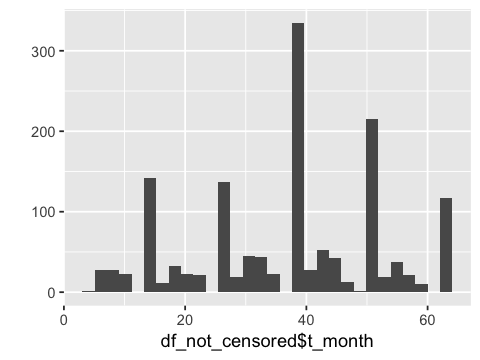

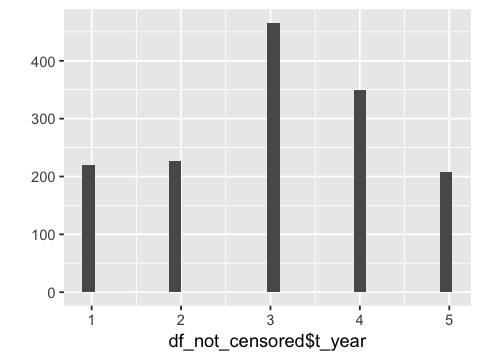

In [6]:
###Histogram of time variable
options(repr.plot.width=4, repr.plot.height=3)

df_not_censored <- filter(df_completa, censored == 0)

##time as monthly
qplot(df_not_censored$t_month, geom="histogram") 

##time of dropout yearly
qplot(df_not_censored$t_year, geom="histogram") 

In fact we can see some kind of seasonallity on the dropout event. Having a lot of dropout events in March (when the academic year starts in Uruguay).Moreover, we can also observe an important amount of students droppingout at year 3 which corresponds to 2012 the year in which students of this sample were suppose to start university. 

Warning message:
“Removed 15 rows containing missing values (geom_point).”

Warning message:
“Removed 13 rows containing missing values (geom_point).”

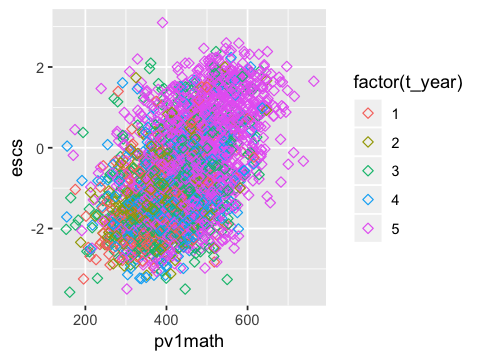

Warning message:
“Removed 13 rows containing missing values (geom_point).”

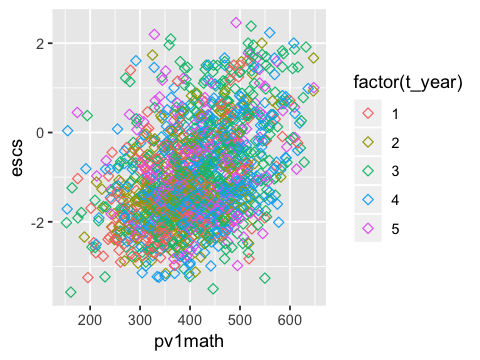

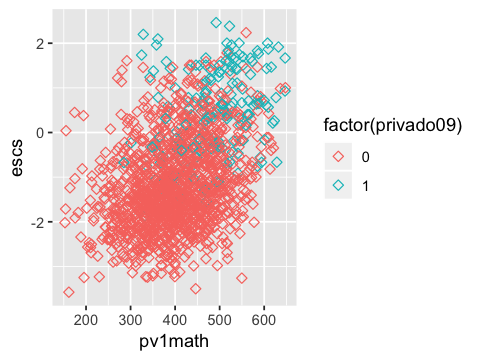

Warning message:
“Removed 15 rows containing non-finite values (stat_boxplot).”

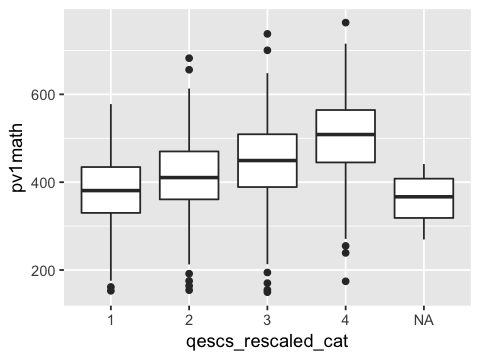

Warning message:
“Removed 15 rows containing non-finite values (stat_boxplot).”

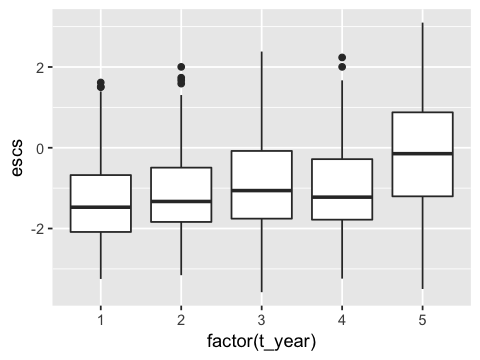

Warning message:
“Removed 15 rows containing non-finite values (stat_boxplot).”

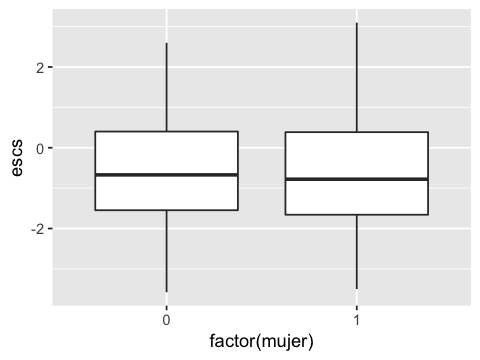

Warning message:
“Removed 15 rows containing non-finite values (stat_boxplot).”

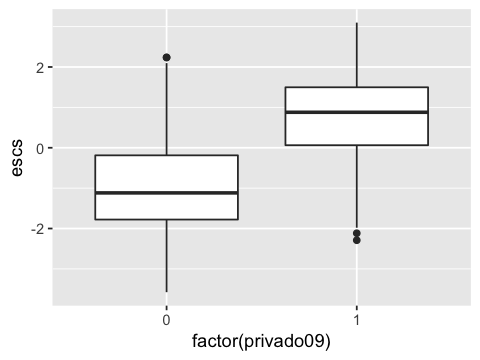

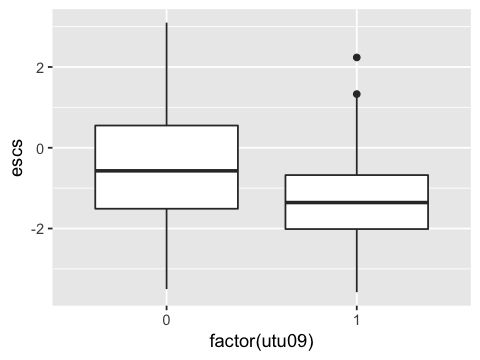

In [118]:
# Basic descriptive plots of our dataset

##scatter plot of math score and socioeconomic level
ggplot(df_completa, aes(x=pv1math, y=escs, colour=factor(t_year)))  +
  geom_point(size=2, shape=23)

ggplot(df_not_censored, aes(x=pv1math, y=escs, colour=factor(t_year)))  +
  geom_point(size=2, shape=23)

ggplot(df_not_censored, aes(x=pv1math, y=escs, colour=factor(privado09)))  +
  geom_point(size=2, shape=23)


###box plot of math score by socioeconomic quartil
p <- ggplot(df_completa, aes(x=qescs_rescaled_cat, y=pv1math)) + 
  geom_boxplot()
print(p)

##
p <- ggplot(df_completa, aes(x=factor(t_year), y=escs)) + 
  geom_boxplot()
print(p)

p <- ggplot(df_completa, aes(x=factor(mujer), y=escs)) + 
  geom_boxplot()
print(p)

p <- ggplot(df_completa, aes(x=factor(privado09), y=escs)) + 
  geom_boxplot()
print(p)


p <- ggplot(df_completa, aes(x=factor(utu09), y=escs)) + 
  geom_boxplot()
print(p)



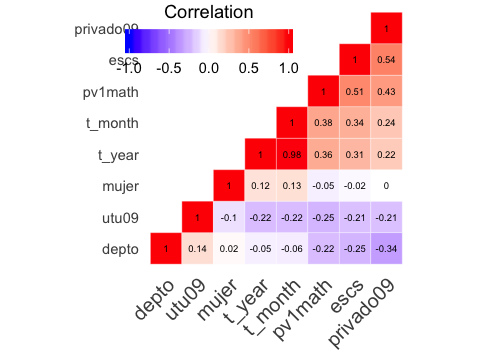

In [271]:
##Plotting correlation heatmap

df_numeric<- df_completa%>%
  select(escs, pv1math, depto, privado09, utu09, mujer, t_year, t_month)

df_numeric<-df_numeric %>%
  filter(df_numeric$escs!="NA's")

cormat<-cor(df_numeric)
cormat <- round(cor(df_numeric),2)

library(reshape2)
melted_cormat <- melt(cormat)


#Get lower triangle of the correlation matrix
get_lower_tri<-function(cormat){
  cormat[upper.tri(cormat)] <- NA
  return(cormat)
}
# Get upper triangle of the correlation matrix
get_upper_tri <- function(cormat){
  cormat[lower.tri(cormat)]<- NA
  return(cormat)
}

upper_tri <- get_upper_tri(cormat)


reorder_cormat <- function(cormat){
  # Use correlation between variables as distance
  dd <- as.dist((1-cormat)/2)
  hc <- hclust(dd)
  cormat <-cormat[hc$order, hc$order]
}

# Reorder the correlation matrix
cormat <- reorder_cormat(cormat)
upper_tri <- get_upper_tri(cormat)
# Melt the correlation matrix
melted_cormat <- melt(upper_tri, na.rm = TRUE)
# Create a ggheatmap
ggheatmap <- ggplot(melted_cormat, aes(Var2, Var1, fill = value))+
  geom_tile(color = "white")+
  scale_fill_gradient2(low = "blue", high = "red", mid = "white", 
                       midpoint = 0, limit = c(-1,1), space = "Lab", 
                       name="Pearson\nCorrelation") +
  theme_minimal()+ # minimal theme
  theme(axis.text.x = element_text(angle = 45, vjust = 1, 
                                   size = 12, hjust = 1))+
  coord_fixed()
# Print the heatmap


ggheatmap + 
  geom_text(aes(Var2, Var1, label = value), color = "black", size = 2) +
  theme(
    axis.title.x = element_blank(),
    axis.title.y = element_blank(),
    panel.grid.major = element_blank(),
    panel.border = element_blank(),
    panel.background = element_blank(),
    axis.ticks = element_blank(),
    legend.justification = c(1, 0),
    legend.position = c(0.6, 0.7),
    legend.direction = "horizontal")+
  guides(fill = guide_colorbar(barwidth = 7, barheight = 1,
                               title.position = "top", title.hjust = 0.5))


With some scatterplots, boxplots and correlation matrix we can observe that many of our variables are highly correlated and may not be independente one from another. For example, the socioeconomic and cultural index is highly correlated to the math grade achived in the PISA test 2009 and to the variable privado09 which corresponds to a dummy variable accounting for students who went to a private school. However, from this descriptive statistic we cannot infere any causality. For instance, we do not know if going to a private school causes student to perform better on the PISA test or if student from private school score better because they come from a family with higher socioeconomic and cultural condition. In terms of our dropout event we do not know whether students of higher socioeconomic level families stay longer in school because they are performing better (higher math level) of because they attended a private school were dropout rates are lower. 

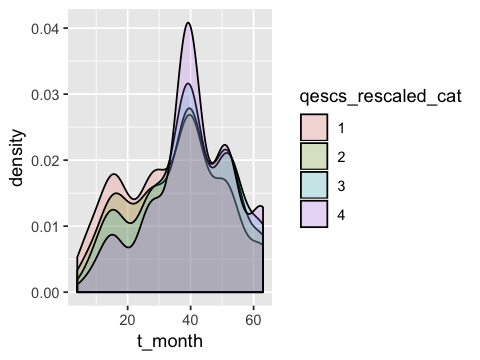

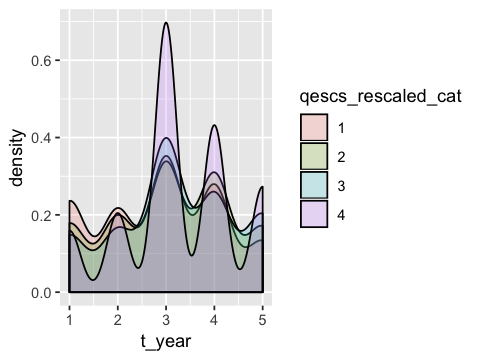

In [98]:
df_completa %>%
  filter(qescs_rescaled_cat!="NA", censored==0) %>%
  ggplot(aes(t_month, fill = qescs_rescaled_cat))+ geom_density(alpha = 0.2)

df_completa %>%
  filter(qescs_rescaled_cat!="NA", censored==0) %>%
  ggplot(aes(t_year, fill = qescs_rescaled_cat))+ geom_density(alpha = 0.2)

# Kaplan Maier non-parametric models

I start by estimating some basic non parametric models to gather more insights of our data. The main drawback of this kind of models is that we can compare different survival functions for different group of students but we cannot control for other variables. As we have stated we can see differences by group that may we explained by other variables. 

Warning message in .pvalue(fit, data = data, method = method, pval = pval, pval.coord = pval.coord, :
“There are no survival curves to be compared. 
 This is a null model.”

Call: survfit(formula = surv_object_months ~ 1, data = df_completa)

      n  events  median 0.95LCL 0.95UCL 
   2608    1468      55      51      63 

Call: survfit(formula = surv_object_months ~ 1, data = df_completa)

 time n.risk n.event survival  std.err lower 95% CI upper 95% CI
    4   2608       1    1.000 0.000383        0.999        1.000
    6   2607      11    0.995 0.001325        0.993        0.998
    7   2596      17    0.989 0.002053        0.985        0.993
    8   2579      16    0.983 0.002550        0.978        0.988
    9   2563      11    0.979 0.002838        0.973        0.984
   10   2552      14    0.973 0.003165        0.967        0.979
   11   2538       8    0.970 0.003335        0.964        0.977
   15   2530     142    0.916 0.005442        0.905        0.926
   16   2388       4    0.914 0.005487        0.903        0.925
   17   2384       8    0.911 0.005574        0.900        0.922
   18   2376      11    0.907 0.005692        0.896        0.918
   19   2365      21    0.899 0.005906        0.887        0.910
   20   2344       8    0.896 0.005985        0.884        0.908
   21   2336      15 

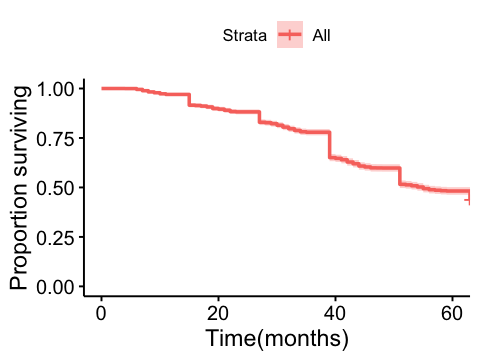

In [31]:
##I first fit the kaplam-maier-estimator with the time in months
# The functions survfit() and Surv() create a life table survival object.
# The life table object is passed to the plot() function to create the KM plot.
surv_object_months <- Surv(time = df_completa$t_month, event = df_completa$stopstudying)
fit_km_monthly <- survfit(surv_object_months ~ 1, data = df_completa)
ggsurvplot(fit_km_monthly, data = df_completa, pval = TRUE, xlab="Time(months)", ylab="Proportion surviving")
fit_km_monthly
summary(fit_km_monthly)

Warning message in .pvalue(fit, data = data, method = method, pval = pval, pval.coord = pval.coord, :
“There are no survival curves to be compared. 
 This is a null model.”

Call: survfit(formula = surv_object_yearly ~ 1, data = df_completa)

      n  events  median 0.95LCL 0.95UCL 
   2608    1468       5       4       5 

Call: survfit(formula = surv_object_yearly ~ 1, data = df_completa)

 time n.risk n.event survival std.err lower 95% CI upper 95% CI
    1   2608     219    0.916 0.00543        0.905        0.927
    2   2389     226    0.829 0.00737        0.815        0.844
    3   2163     466    0.651 0.00934        0.633        0.669
    4   1697     350    0.516 0.00979        0.498        0.536
    5   1347     207    0.437 0.00971        0.418        0.457

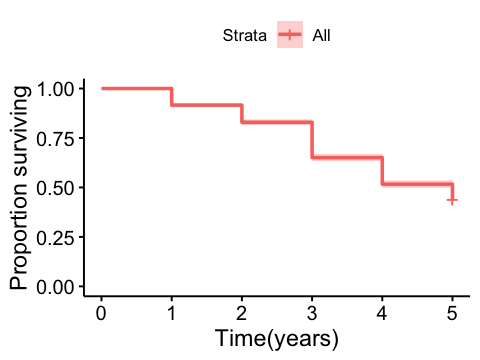

In [32]:
##Then I fit the kaplam maier estimator with the time in years
surv_object_yearly <- Surv(time = df_completa$t_year, event = df_completa$stopstudying)
fit_km_yearly <- survfit(surv_object_yearly ~ 1, data = df_completa)
ggsurvplot(fit_km_yearly, data = df_completa, pval = TRUE, xlab="Time(years)", ylab="Proportion surviving")
fit_km_yearly
summary(fit_km_yearly)

Call: survfit(formula = surv_object_months ~ qescs_rescaled_cat, data = df_completa)

   9 observations deleted due to missingness 
                       n events median 0.95LCL 0.95UCL
qescs_rescaled_cat=1 633    476     40      39      43
qescs_rescaled_cat=2 591    413     51      43      51
qescs_rescaled_cat=3 624    339     63      54      63
qescs_rescaled_cat=4 751    233     NA      NA      NA

Call: survfit(formula = surv_object_months ~ qescs_rescaled_cat, data = df_completa)

9 observations deleted due to missingness 
                qescs_rescaled_cat=1 
 time n.risk n.event survival std.err lower 95% CI upper 95% CI
    6    633       9    0.986 0.00471        0.977        0.995
    7    624       9    0.972 0.00661        0.959        0.985
    8    615       8    0.959 0.00789        0.944        0.975
    9    607       3    0.954 0.00831        0.938        0.971
   10    604       7    0.943 0.00921        0.925        0.961
   11    597       3    0.938 0.00956        0.920        0.957
   15    594      54    0.853 0.01407        0.826        0.881
   16    540       3    0.848 0.01426        0.821        0.877
   17    537       5    0.840 0.01455        0.812        0.869
   18    532       4    0.834 0.01478        0.806        0.864
   19    528      10    0.818 0.01533        0.789        0.849
   20    518       5    0.810 0.01558        0.780        0.842
 

Call: survfit(formula = surv_object_yearly ~ qescs_rescaled_cat, data = df_completa)

   9 observations deleted due to missingness 
                       n events median 0.95LCL 0.95UCL
qescs_rescaled_cat=1 633    476      4       3       4
qescs_rescaled_cat=2 591    413      4       4       4
qescs_rescaled_cat=3 624    339      5       5       5
qescs_rescaled_cat=4 751    233     NA      NA      NA

Call: survfit(formula = surv_object_yearly ~ qescs_rescaled_cat, data = df_completa)

9 observations deleted due to missingness 
                qescs_rescaled_cat=1 
 time n.risk n.event survival std.err lower 95% CI upper 95% CI
    1    633      93    0.853  0.0141        0.826        0.881
    2    540      84    0.720  0.0178        0.686        0.756
    3    456     138    0.502  0.0199        0.465        0.543
    4    318     109    0.330  0.0187        0.295        0.369
    5    209      52    0.248  0.0172        0.217        0.284

                qescs_rescaled_cat=2 
 time n.risk n.event survival std.err lower 95% CI upper 95% CI
    1    591      62    0.895  0.0126        0.871        0.920
    2    529      68    0.780  0.0170        0.747        0.814
    3    461     117    0.582  0.0203        0.544        0.623
    4    344     107    0.401  0.0202        0.363        0.443
    5    237      59    0.301  0.0189        0.266        0.341

                qescs_res

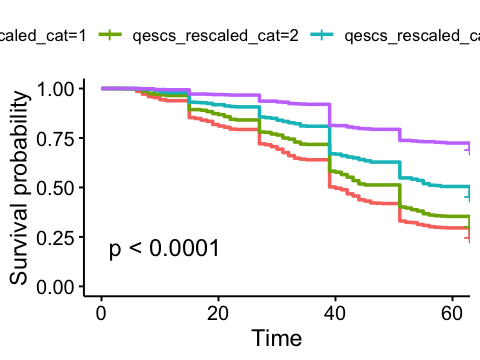

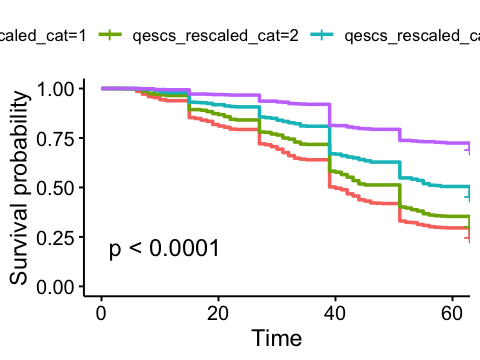

In [33]:
# I create  life tables and KM plots broken out by socioeconomics level for the monthly t variable, as the socioeconomic level is our variable of interest.
fit_monthly_escs <- survfit(surv_object_months ~ qescs_rescaled_cat, data = df_completa)
fit_monthly_escs
summary(fit_monthly_escs)
ggsurvplot(fit_monthly_escs, data = df_completa, pval = TRUE)


# Createlife tables and KM plots broken out by socioeconomics level for the yearly
fit_yearly_escs <- survfit(surv_object_yearly ~ qescs_rescaled_cat, data = df_completa)
fit_yearly_escs
summary(fit_yearly_escs)
ggsurvplot(fit_monthly_escs, data = df_completa, pval = TRUE)

With the survdiff() we can test for survival curve differences. 
This function implements the G-rho family of Harrington and Fleming (1982), with weights on each death of $S(t)^ rho$, where S is the Kaplan-Meier estimate of survival. With rho = 0 this is the log-rank or Mantel-Haenszel test, and with rho = 1 it is equivalent to the Peto & Peto modification of the Gehan-Wilcoxon test.If the right hand side of the formula consists only of an offset term, then a one sample test is done. 

In [34]:
#TEST SURVIVAL CURVE DIFFERENCE
# Perform the log rank test using the R function survdiff() for the monthly and yearly data 

surv.diff.escs_m <- survdiff(surv_object_months ~ qescs_rescaled_cat, data = df_completa)
surv.diff.escs_m


surv.diff.escs_y <- survdiff(surv_object_yearly ~ qescs_rescaled_cat, data = df_completa)
surv.diff.escs_y

Call:
survdiff(formula = surv_object_months ~ qescs_rescaled_cat, data = df_completa)

n=2599, 9 observations deleted due to missingness.

                       N Observed Expected (O-E)^2/E (O-E)^2/V
qescs_rescaled_cat=1 633      476      287    124.93    169.36
qescs_rescaled_cat=2 591      413      299     43.30     59.22
qescs_rescaled_cat=3 624      339      363      1.61      2.33
qescs_rescaled_cat=4 751      233      512    151.94    256.23

 Chisq= 353  on 3 degrees of freedom, p= <2e-16 

Call:
survdiff(formula = surv_object_yearly ~ qescs_rescaled_cat, data = df_completa)

n=2599, 9 observations deleted due to missingness.

                       N Observed Expected (O-E)^2/E (O-E)^2/V
qescs_rescaled_cat=1 633      476      300    103.37    156.11
qescs_rescaled_cat=2 591      413      306     37.38     56.67
qescs_rescaled_cat=3 624      339      361      1.34      2.14
qescs_rescaled_cat=4 751      233      494    137.90    251.69

 Chisq= 339  on 3 degrees of freedom, p= <2e-16 

This simple long-rank test indicates that the survival time are indeed different amoung students from different socioeconomic level, being the students of the higher socioeconomic group expected to survive longer. However, as we have seen there are other covariates that can also affect the survival time of the students. Therefore, other methods as the proportional hazard model should be estimated in order to asses for the differences controlling for other characteristics.

For example it is possible to observe that the survival functions are also different among male and women students and among other characteristics.

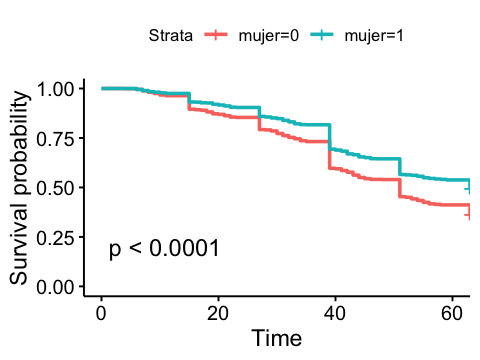

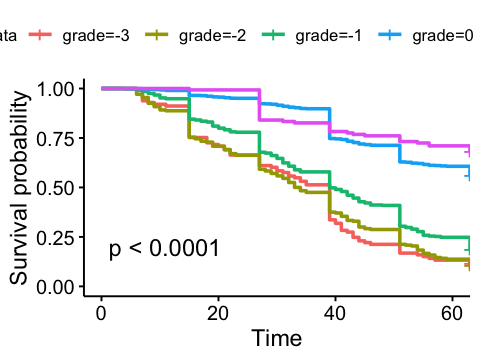

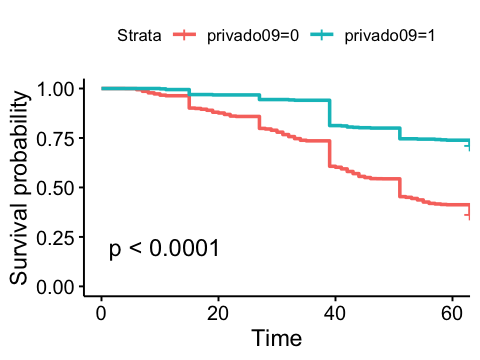

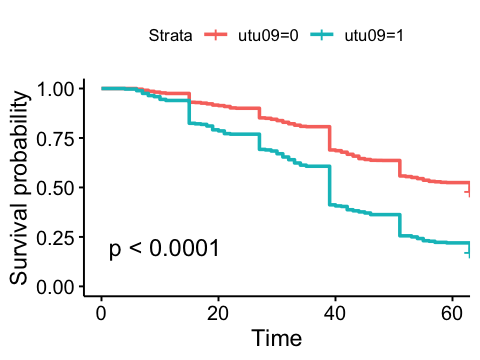

In [35]:
###Kaplam maier estimators by other different categorial variables with monthly data

fit2 <- survfit(surv_object_months ~ mujer, data = df_completa)
ggsurvplot(fit2, data = df_completa, pval = TRUE)

fit3 <- survfit(surv_object_months ~ grade, data = df_completa)
ggsurvplot(fit3, data = df_completa, pval = TRUE)

fit4 <- survfit(surv_object_months ~ privado09, data = df_completa)
ggsurvplot(fit4, data = df_completa, pval = TRUE)

fit5 <- survfit(surv_object_months ~ utu09, data = df_completa)
ggsurvplot(fit5, data = df_completa, pval = TRUE)

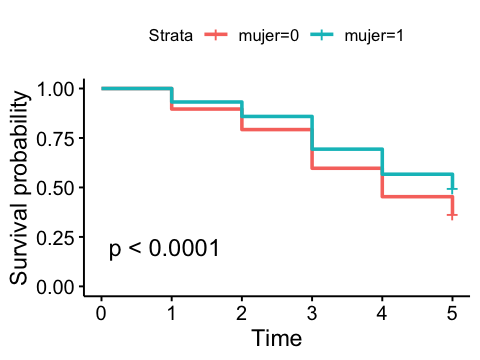

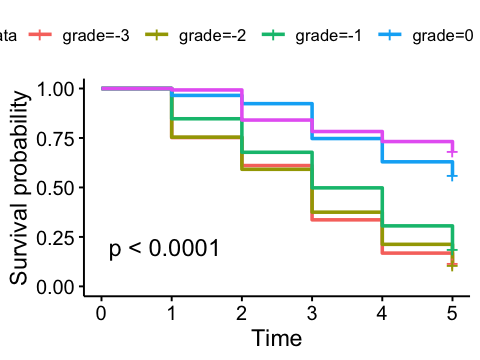

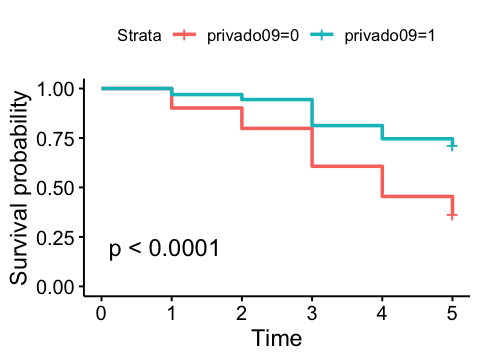

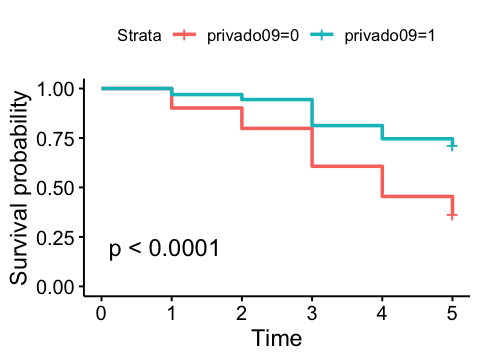

In [36]:
#I now fit the models with the time in years
###KAPLAN MAIER
surv_object_years <- Surv(time = df_completa$t_year, event = df_completa$stopstudying)

fit2y <- survfit(surv_object_years ~ mujer, data = df_completa)
ggsurvplot(fit2y, data = df_completa, pval = TRUE)

fit3y <- survfit(surv_object_years ~ grade, data = df_completa)
ggsurvplot(fit3y, data = df_completa, pval = TRUE)

fit4y <- survfit(surv_object_years ~ privado09, data = df_completa)
ggsurvplot(fit4y, data = df_completa, pval = TRUE)

fit5y <- survfit(surv_object_years ~ utu09, data = df_completa)
ggsurvplot(fit4y, data = df_completa, pval = TRUE)



# Cox proportional hazard models

In order to estimate the proportional hazard I will try different variations of the cox proportional hazard model. 
I will estimate the models with the time variable meassured in months as well as in years.
Moreover, I will use different methods to account for ties (Efron, Breslow, C-log-log and Random Substraction). Finally I will compare all the resaults. 

__Model 1: Efron and time in months__

Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

Call:
coxph(formula = surv_object_months ~ mujer + grade + utu09 + 
    privado09 + qescs_rescaled_cat + pv1math, data = df_completa, 
    method = "efron")

  n= 2599, number of events= 1461 
   (9 observations deleted due to missingness)

                          coef  exp(coef)   se(coef)      z Pr(>|z|)    
mujer               -0.3642896  0.6946900  0.0542085 -6.720 1.82e-11 ***
grade               -0.2622828  0.7692934  0.0332664 -7.884 3.16e-15 ***
utu09                0.2171237  1.2424978  0.0703814  3.085 0.002036 ** 
privado09           -0.3648577  0.6942955  0.0947785 -3.850 0.000118 ***
qescs_rescaled_cat2 -0.0613447  0.9404990  0.0680107 -0.902 0.367065    
qescs_rescaled_cat3 -0.2778152  0.7574368  0.0741599 -3.746 0.000180 ***
qescs_rescaled_cat4 -0.6762099  0.5085408  0.0924637 -7.313 2.61e-13 ***
pv1math             -0.0026550  0.9973485  0.0003657 -7.260 3.88e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                    exp(coef) exp(

                          rho    chisq      p
mujer               -0.031821 1.525522 0.2168
grade                0.023600 0.793292 0.3731
utu09               -0.005987 0.056818 0.8116
privado09           -0.045977 2.995296 0.0835
qescs_rescaled_cat2  0.034122 1.703759 0.1918
qescs_rescaled_cat3  0.016337 0.393517 0.5305
qescs_rescaled_cat4 -0.000424 0.000259 0.9872
pv1math              0.003903 0.020255 0.8868
GLOBAL                     NA 8.685900 0.3695

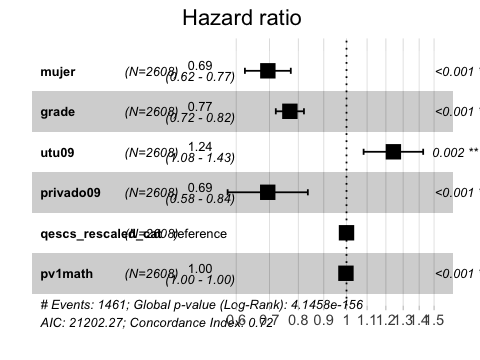

In [71]:
#Cox proportional hazards model:

##Time in months
##Method: Efron

fit.coxph_efronm <- coxph(surv_object_months ~ mujer + grade + utu09 + privado09+ qescs_rescaled_cat +pv1math ,  
                   data = df_completa, method="efron")

ggforest(fit.coxph_efronm, data = df_completa)

summary(fit.coxph_efronm)

test.ph <- cox.zph(fit.coxph_efronm)
test.ph

coef_efron_m<-fit.coxph_efronm$coefficients

__Model 2: Efron and time in years__

Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

Call:
coxph(formula = surv_object_years ~ mujer + grade + utu09 + privado09 + 
    qescs_rescaled_cat + pv1math, data = df_completa, method = "efron")

  n= 2599, number of events= 1461 
   (9 observations deleted due to missingness)

                          coef  exp(coef)   se(coef)      z Pr(>|z|)    
mujer               -0.3649617  0.6942232  0.0541459 -6.740 1.58e-11 ***
grade               -0.2411055  0.7857587  0.0331834 -7.266 3.71e-13 ***
utu09                0.2402147  1.2715222  0.0702552  3.419 0.000628 ***
privado09           -0.3468912  0.7068822  0.0948680 -3.657 0.000256 ***
qescs_rescaled_cat2 -0.0533816  0.9480182  0.0680467 -0.784 0.432756    
qescs_rescaled_cat3 -0.2695025  0.7637594  0.0741181 -3.636 0.000277 ***
qescs_rescaled_cat4 -0.6644180  0.5145729  0.0925473 -7.179 7.01e-13 ***
pv1math             -0.0027416  0.9972621  0.0003655 -7.502 6.28e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                    exp(coef) exp(-coef)

                         rho    chisq      p
mujer               -0.03305  1.64198 0.2001
grade                0.01710  0.41638 0.5187
utu09               -0.01155  0.20999 0.6468
privado09           -0.05836  4.83690 0.0279
qescs_rescaled_cat2  0.03332  1.62527 0.2024
qescs_rescaled_cat3  0.01243  0.22747 0.6334
qescs_rescaled_cat4 -0.00522  0.03937 0.8427
pv1math              0.00253  0.00846 0.9267
GLOBAL                    NA 11.13323 0.1943

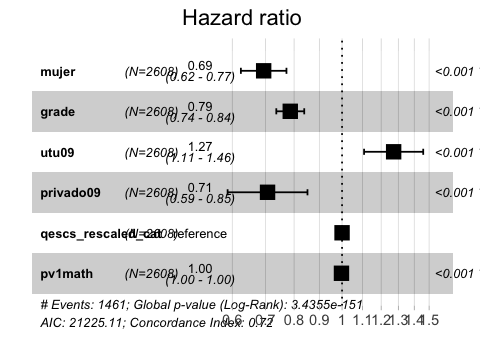

In [72]:
#Cox proportional hazards model:

##Time in years
##Method: Efron

fit.coxph_efron_y <- coxph(surv_object_years ~ mujer + grade + utu09 +privado09+ qescs_rescaled_cat +pv1math,  
                   data = df_completa, method="efron")

ggforest(fit.coxph_efron_y, data = df_completa)
summary(fit.coxph_efron_y)

coef_efron_y<-fit.coxph_efron_y$coefficients

test.ph_efron_y <- cox.zph(fit.coxph_efron_y)
test.ph_efron_y

__Model 3: Breslow and time in months__

Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

Call:
coxph(formula = surv_object_months ~ mujer + grade + utu09 + 
    privado09 + qescs_rescaled_cat + pv1math, data = df_completa, 
    method = "breslow")

  n= 2599, number of events= 1461 
   (9 observations deleted due to missingness)

                          coef  exp(coef)   se(coef)      z Pr(>|z|)    
mujer               -0.3439937  0.7089334  0.0541919 -6.348 2.19e-10 ***
grade               -0.2579026  0.7726705  0.0333181 -7.741 9.89e-15 ***
utu09                0.1867616  1.2053399  0.0703206  2.656 0.007911 ** 
privado09           -0.3646354  0.6944498  0.0948410 -3.845 0.000121 ***
qescs_rescaled_cat2 -0.0585277  0.9431522  0.0679884 -0.861 0.389322    
qescs_rescaled_cat3 -0.2639107  0.7680421  0.0741863 -3.557 0.000375 ***
qescs_rescaled_cat4 -0.6536226  0.5201580  0.0925337 -7.064 1.62e-12 ***
pv1math             -0.0025093  0.9974938  0.0003661 -6.855 7.15e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                    exp(coef) ex

                          rho    chisq      p
mujer               -0.028682 1.24e+00 0.2658
grade                0.021922 6.85e-01 0.4078
utu09               -0.010695 1.80e-01 0.6710
privado09           -0.044520 2.81e+00 0.0938
qescs_rescaled_cat2  0.031982 1.49e+00 0.2216
qescs_rescaled_cat3  0.016730 4.13e-01 0.5206
qescs_rescaled_cat4 -0.000153 3.37e-05 0.9954
pv1math              0.008384 9.35e-02 0.7598
GLOBAL                     NA 8.03e+00 0.4304

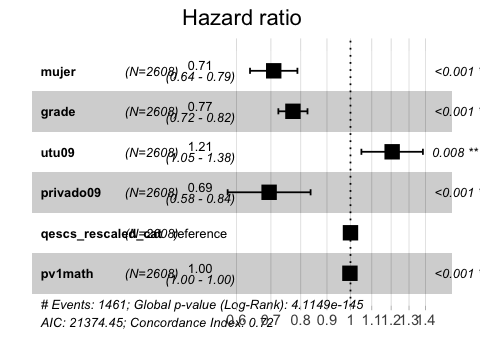

In [73]:
#Cox proportional hazards model:

##Time in months
##Method: Breslow

fit.coxph_breslowm <- coxph(surv_object_months ~ mujer + grade + utu09 + privado09 + qescs_rescaled_cat +pv1math,  
                          data = df_completa, method="breslow")

ggforest(fit.coxph_breslowm, data = df_completa)

summary(fit.coxph_breslowm)

test.ph <- cox.zph(fit.coxph_breslowm)
test.ph

coef_breslow_m<-fit.coxph_breslowm$coefficients


__Model 4: Breslow and time in years__

Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

Call:
coxph(formula = surv_object_years ~ mujer + grade + utu09 + privado09 + 
    qescs_rescaled_cat + pv1math, data = df_completa, method = "breslow")

  n= 2599, number of events= 1461 
   (9 observations deleted due to missingness)

                          coef  exp(coef)   se(coef)      z Pr(>|z|)    
mujer               -0.3239593  0.7232796  0.0540442 -5.994 2.04e-09 ***
grade               -0.2116873  0.8092177  0.0332357 -6.369 1.90e-10 ***
utu09                0.2033382  1.2254869  0.0700368  2.903 0.003692 ** 
privado09           -0.3240575  0.7232087  0.0951163 -3.407 0.000657 ***
qescs_rescaled_cat2 -0.0429442  0.9579649  0.0680244 -0.631 0.527841    
qescs_rescaled_cat3 -0.2348933  0.7906552  0.0740973 -3.170 0.001524 ** 
qescs_rescaled_cat4 -0.6083518  0.5442472  0.0927136 -6.562 5.32e-11 ***
pv1math             -0.0025209  0.9974823  0.0003664 -6.881 5.95e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                    exp(coef) exp(-coe

ERROR: Error in p.values(fit.coxph_breslow_y): no se pudo encontrar la función "p.values"


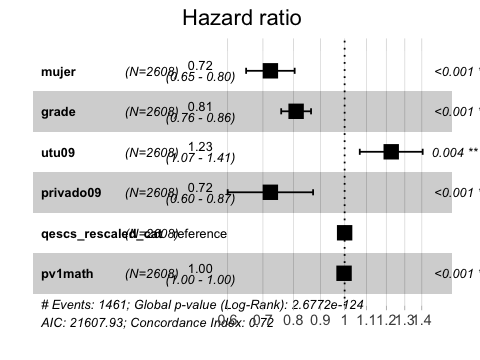

In [74]:
#Cox proportional hazards model:

##Time in years
##Method: Breslow


##BRESLOW METHOD
fit.coxph_breslow_y <- coxph(surv_object_years ~ mujer + grade + utu09+privado09+ qescs_rescaled_cat +pv1math,  
                         data = df_completa, method="breslow")
ggforest(fit.coxph_breslow_y, data = df_completa)
summary(fit.coxph_breslow_y)

coef_breslow_y<-fit.coxph_breslow_y$coefficients

p.values(fit.coxph_breslow_y)


test.ph_breslow_y <- cox.zph(fit.coxph_breslow_y)
test.ph_breslow_y


__Model 5: Complementary log-log and time in years__

In [75]:
# In order to estimate the discrete method I need to "extend" the dataset and create the person-period file

#make person period file with time variable year
pp<-survSplit(df_completa, cut=seq(1,5,1),start="start", end="t_year", event="stopstudying", episode="year")
fit_glm_years<-glm(stopstudying~mujer + grade + utu09+ privado09+ qescs_rescaled_cat +pv1math, family=binomial(link="cloglog"), data=pp)
summary(fit_glm_years)


Call:
glm(formula = stopstudying ~ mujer + grade + utu09 + privado09 + 
    qescs_rescaled_cat + pv1math, family = binomial(link = "cloglog"), 
    data = pp)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.3921  -0.5887  -0.4599  -0.3297   2.6756  

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -0.4662548  0.1747188  -2.669 0.007617 ** 
mujer               -0.3252730  0.0541097  -6.011 1.84e-09 ***
grade               -0.2122506  0.0334402  -6.347 2.19e-10 ***
utu09                0.2032120  0.0702201   2.894 0.003805 ** 
privado09           -0.3306466  0.0952136  -3.473 0.000515 ***
qescs_rescaled_cat2 -0.0375469  0.0684196  -0.549 0.583161    
qescs_rescaled_cat3 -0.2297420  0.0744116  -3.087 0.002019 ** 
qescs_rescaled_cat4 -0.6068086  0.0928306  -6.537 6.29e-11 ***
pv1math             -0.0025107  0.0003703  -6.779 1.21e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion p

__Model 6: Complementary log-log with time in months__

In [76]:
#make person period file with time variable month
pp2<-survSplit(df_completa, cut=seq(1,63,1),start="start", end="t_month", event="stopstudying", episode="year")
fit_glm_months<-glm(stopstudying~mujer + grade + utu09+ privado09 + qescs_rescaled_cat +pv1math, family=binomial(link="cloglog"), data=pp2)
summary(fit_glm_months)


Call:
glm(formula = stopstudying ~ mujer + grade + utu09 + privado09 + 
    qescs_rescaled_cat + pv1math, family = binomial(link = "cloglog"), 
    data = pp2)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.3563  -0.1718  -0.1401  -0.1074   3.4879  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -3.171502   0.173789 -18.249  < 2e-16 ***
mujer               -0.301675   0.053986  -5.588 2.30e-08 ***
grade               -0.206351   0.033225  -6.211 5.27e-10 ***
utu09                0.164536   0.069810   2.357 0.018428 *  
privado09           -0.336506   0.095212  -3.534 0.000409 ***
qescs_rescaled_cat2 -0.035266   0.068003  -0.519 0.604042    
qescs_rescaled_cat3 -0.217391   0.074177  -2.931 0.003382 ** 
qescs_rescaled_cat4 -0.586043   0.092898  -6.308 2.82e-10 ***
pv1math             -0.002287   0.000368  -6.216 5.11e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter 

__Model 7: Random Subtraction with time in years__

In [62]:
#Modify time variable for tied events by subtracting small value from uniform distribution [0, 1000]*
# Get a vector of n numbers from 0 to 0.00001
runif<-runif(2608, min=0, max=0.001)
#runif<-as.matrix(runif)
#runif

In [63]:
df_completa$t_year_cont<-df_completa$t_year-runif
df_completa$t_month_cont<-df_completa$t_month-runif
#head(df_completa)

In [64]:
##time as monthly
library(dplyr)
df_completa %>% 
    summarise(n = n_distinct(t_month_cont))

surv_object_years_cont <- Surv(time = df_completa$t_year_cont, event = df_completa$stopstudying)
surv_object_month_cont <- Surv(time = df_completa$t_month_cont, event = df_completa$stopstudying)

n
2608


Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

Call:
coxph(formula = surv_object_years_cont ~ mujer + grade + utu09 + 
    privado09 + qescs_rescaled_cat + pv1math, data = df_completa, 
    method = "breslow")

  n= 2599, number of events= 1461 
   (9 observations deleted due to missingness)

                          coef  exp(coef)   se(coef)      z Pr(>|z|)    
mujer               -0.3430619  0.7095943  0.0541255 -6.338 2.32e-10 ***
grade               -0.2348754  0.7906694  0.0332290 -7.068 1.57e-12 ***
utu09                0.2368539  1.2672560  0.0704131  3.364 0.000769 ***
privado09           -0.3404071  0.7114806  0.0950299 -3.582 0.000341 ***
qescs_rescaled_cat2 -0.0803034  0.9228363  0.0680761 -1.180 0.238154    
qescs_rescaled_cat3 -0.2641361  0.7678690  0.0741733 -3.561 0.000369 ***
qescs_rescaled_cat4 -0.6596413  0.5170368  0.0925241 -7.129 1.01e-12 ***
pv1math             -0.0026767  0.9973269  0.0003648 -7.337 2.19e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                    exp(coef

ERROR: Error in p.values(fit.coxph_breslow_y_cont): no se pudo encontrar la función "p.values"


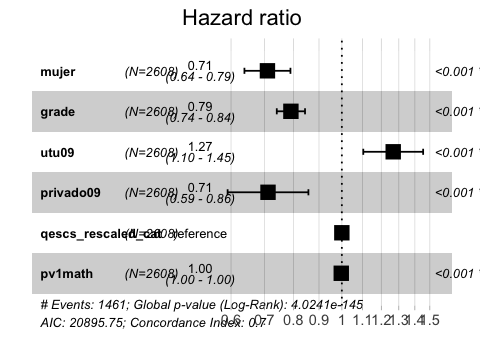

In [77]:
##BRESLOW METHOD with year variable with no ties
fit.coxph_breslow_y_cont <- coxph(surv_object_years_cont ~ mujer + grade + utu09+privado09+ qescs_rescaled_cat +pv1math,  
                         data = df_completa, method="breslow")
ggforest(fit.coxph_breslow_y_cont, data = df_completa)
summary(fit.coxph_breslow_y_cont)

coef_breslow_y_cont<-fit.coxph_breslow_y_cont$coefficients

p.values(fit.coxph_breslow_y_cont)


test.ph_breslow_y_cont <- cox.zph(fit.coxph_breslow_y_cont)
test.ph_breslow_y_cont


__Model 8: Random Subtraction with time in months__

Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

Call:
coxph(formula = surv_object_month_cont ~ mujer + grade + utu09 + 
    privado09 + qescs_rescaled_cat + pv1math, data = df_completa, 
    method = "breslow")

  n= 2599, number of events= 1461 
   (9 observations deleted due to missingness)

                          coef  exp(coef)   se(coef)      z Pr(>|z|)    
mujer               -0.3562370  0.7003066  0.0541866 -6.574 4.89e-11 ***
grade               -0.2615666  0.7698446  0.0333020 -7.854 4.02e-15 ***
utu09                0.2190168  1.2448522  0.0704578  3.108 0.001881 ** 
privado09           -0.3648682  0.6942882  0.0948904 -3.845 0.000120 ***
qescs_rescaled_cat2 -0.0826501  0.9206732  0.0680514 -1.215 0.224547    
qescs_rescaled_cat3 -0.2779163  0.7573602  0.0742184 -3.745 0.000181 ***
qescs_rescaled_cat4 -0.6795984  0.5068205  0.0924890 -7.348 2.01e-13 ***
pv1math             -0.0025925  0.9974108  0.0003652 -7.098 1.27e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                    exp(coef

                          rho    chisq     p
mujer               -2.34e-02 8.21e-01 0.365
grade                5.26e-02 3.95e+00 0.047
utu09                7.17e-03 8.16e-02 0.775
privado09           -2.73e-02 1.06e+00 0.303
qescs_rescaled_cat2  1.95e-02 5.56e-01 0.456
qescs_rescaled_cat3  1.65e-02 4.02e-01 0.526
qescs_rescaled_cat4  6.03e-04 5.25e-04 0.982
pv1math              4.24e-05 2.38e-06 0.999
GLOBAL                     NA 8.43e+00 0.393

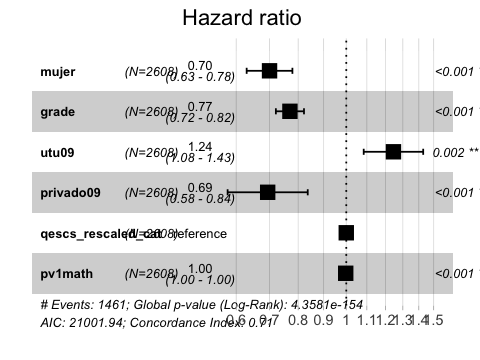

In [78]:
##BRESLOW METHOD with month variable with no tied
fit.coxph_breslow_m_cont <- coxph(surv_object_month_cont ~ mujer + grade + utu09 + privado09 + qescs_rescaled_cat +pv1math,  
                          data = df_completa, method="breslow")

ggforest(fit.coxph_breslow_m_cont, data = df_completa)

summary(fit.coxph_breslow_m_cont)

test.ph <- cox.zph(fit.coxph_breslow_m_cont)
test.ph

coef_breslow_m_cont<-fit.coxph_breslow_m_cont$coefficients

In [79]:
###I create the coefficient table with all the estimations

coef_glm_y<-as.matrix(round(fit_glm_years$coefficients,2))
coef_glm_m<-as.matrix(round(fit_glm_months$coefficients,2))
coef_glm_y<-coef_glm_y[-1, ] 
coef_glm_m<-coef_glm_m[-1, ] 

coefficient_table<-cbind(coef_breslow_y,coef_efron_y,coef_breslow_m, coef_efron_m)
coefficient_table<-round(coefficient_table,2)

coefficient_table_total<-cbind(coefficient_table,coef_glm_y,coef_glm_m)
coef_breslow_y_cont<-round(coef_breslow_y_cont,2)
coef_breslow_m_cont<-round(coef_breslow_m_cont,2)

coefficient_table_total<-cbind(coefficient_table_total,coef_breslow_m_cont, coef_breslow_y_cont)


In [81]:
##I create a table to compare the p_values

coeffs <- round(coef(summary(fit.coxph_efronm)),5)
p_values_efron_m<-as.matrix(coeffs[,5])

coeffs <- round(coef(summary(fit.coxph_efron_y)),5)
p_values_efron_y<-as.matrix(coeffs[,5])

coeffs <- round(coef(summary(fit.coxph_breslow_y)),5)
p_values_breslow_y<-as.matrix(coeffs[,5])

coeffs <- round(coef(summary(fit.coxph_breslowm)),5)
p_values_breslow_m<-as.matrix(coeffs[,5])

p_values_glm_y<-round(summary(fit_glm_years)$coefficients[,4],5)
p_values_glm_y<-as.matrix(p_values_glm_y)
p_values_glm_y<-p_values_glm_y[-1, ]
p_values_glm_y<-as.matrix(p_values_glm_y)

p_values_glm_m<-round(summary(fit_glm_months)$coefficients[,4],5)
p_values_glm_m<-as.matrix(p_values_glm_m)
p_values_glm_m<-p_values_glm_m[-1, ]
p_values_glm_m<-as.matrix(p_values_glm_m)


coeffs <- round(coef(summary(fit.coxph_breslow_m_cont)),5)
p_values_breslow_m_cont<-as.matrix(coeffs[,5])

coeffs <- round(coef(summary(fit.coxph_breslow_y_cont)),5)
p_values_breslow_y_cont<-as.matrix(coeffs[,5])


p_values_total<-cbind(p_values_breslow_y,p_values_efron_y, p_values_breslow_m, p_values_efron_m,p_values_glm_y,p_values_glm_m, p_values_breslow_m_cont,p_values_breslow_y_cont)

colnames(p_values_total) <- c("p_values_breslow_y","p_values_efron_y","p_values_breslow_m", "p_values_efron_m", "p_values_glm_y","p_values_glm_m", "coxph_breslow_m_cont" ,"coxph_breslow_y_cont")

coefficient_table_total
p_values_total


,coef_breslow_y,coef_efron_y,coef_breslow_m,coef_efron_m,coef_glm_y,coef_glm_m,coef_breslow_m_cont,coef_breslow_y_cont
mujer,-0.32,-0.36,-0.34,-0.36,-0.33,-0.30,-0.36,-0.34
grade,-0.21,-0.24,-0.26,-0.26,-0.21,-0.21,-0.26,-0.23
utu09,0.20,0.24,0.19,0.22,0.20,0.16,0.22,0.24
privado09,-0.32,-0.35,-0.36,-0.36,-0.33,-0.34,-0.36,-0.34
qescs_rescaled_cat2,-0.04,-0.05,-0.06,-0.06,-0.04,-0.04,-0.08,-0.08
qescs_rescaled_cat3,-0.23,-0.27,-0.26,-0.28,-0.23,-0.22,-0.28,-0.26
qescs_rescaled_cat4,-0.61,-0.66,-0.65,-0.68,-0.61,-0.59,-0.68,-0.66
pv1math,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


,p_values_breslow_y,p_values_efron_y,p_values_breslow_m,p_values_efron_m,p_values_glm_y,p_values_glm_m,coxph_breslow_m_cont,coxph_breslow_y_cont
mujer,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
grade,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
utu09,0.00369,0.00063,0.00791,0.00204,0.00380,0.01843,0.00188,0.00077
privado09,0.00066,0.00026,0.00012,0.00012,0.00052,0.00041,0.00012,0.00034
qescs_rescaled_cat2,0.52784,0.43276,0.38932,0.36706,0.58316,0.60404,0.22455,0.23815
qescs_rescaled_cat3,0.00152,0.00028,0.00037,0.00018,0.00202,0.00338,0.00018,0.00037
qescs_rescaled_cat4,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
pv1math,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


# Conclusions:

By taking a quick look at all the estimations we can think that the coefficient and the p-values of all the 8 models are very similar. In all the 8 models all the variables seem to be significant except for the category 2 of the socioeconomic and cultural level when omitting category 1 (lowest socioeconomic level).

In particular, in the Cox Proportional hazard estimation it is easier to interpret the exp(coef). A value of < 1 says that an increase in one unit for that particular variable, will decrease the probability of experiencing the "death event" throughout the observation period. In our case the only variable that seems to increase the probability of dropping out is utu09 (which stands for the students who at the age of 15 were attending technical schools).
On the other hand, being a woman, not having repeated a year before the age of 15 and having higher socioeconomic and cultural level seem to be variables that decrease the probability of dropping out. Higher resaults in the math PISA test in 2009 seem to be significant but with a very small coefficient. 

Moreover, with any of this estimations we would conclude that being of the highest socioeconomic levels (4 and 3) affects in a positive way the probability of surviving when comparing to students of the lowest socioeconomic level even when school characteristics and performance are controlled. On the other hand, there does not seem to be difference in the probability of surviving among students of socioeconomic level 2 and 1 when controlling for other variables. 

If we take a closer look at the estimations and compare Breslow method with Efron method we can observe that the coefficients estimated with the Breslow method are always in absolute values smaller than the coefficient estimated with the Efron method. This observation is in accordance with the conclusions drawn by Hertz-Picciotto and Rockhill(1977) and Borucka (2014) who also indicate a tendency for Breslow approximation to underestimate
parameters in the Cox model.

Moreoever, we can observe that the Breslow estimation is very similar to the complementary-log-log when estimating the models with the year variable. On the other hand the complenetary log-log coefficient's, which is recommended to be used with discrete time variable, estimates much lower coefficients when taking into account the monthly data. This would suggest that the complementary log-log estimation underestimates the resaults when accounting with several time periods and less ties.  

Finally when comparing the cox proportional hazard models estimated with the year variable and the monthly time specification we can observe slight differences. As explained by Singer and Willet (2003) in the cox method the event times play a role only through their relative ranking. We only need to know the rank order of the event time. You would obtain identical parameter estimates, standard errors, and goodnees of-fit statistics wheather you analyzed time assesed in days, weeks, months or years as long as you do not alter their ranking. If we considere that our monthly data is accurate and correclty ranks the order of our data it would be convenient to estimate it with such information. However, as observing the students in many different moments can be much more expensive and still could not be accurate enough to correctly order our observations I strongly believe that the yearly time specification estimated with the complementary-log-log discrete model is prefered in this case. 

__Comparing fit__

Finally, there are many ways of comparing different models. AIC (Akaike Information Criterion) and Bayesian Information Criterion (BIC) are recommended when comparing nonnested models. The smaller these values, the better fit the model demonstrates. Both AIC and BIC are calculated by being penalized based on the number of parameters. In addition, a BIC calculation involves the number of events (number of participants who experienced the event). The equations of AIC and
BIC are as follows:

AIC = -2LL + 2p

BIC = -2LL + $[{ln(E)}p]$

Where LL denotes log-likelihood statistic, p stands for number of parameters and $E$ presents number of events



In [85]:
AIC_values<-c("21225", "21202" ,"21607", "21374", "15387", "7773", "21001", "20895")

In [87]:
AIC_values<-as.matrix(AIC_values)

In [88]:
rownames(AIC_values)<-c("coef_efron_y","coef_efron_m", "coef_breslow_y", "coef_breslow_m", "coef_glm_m", "coef_glm_y", "coef_breslow_m_conf", "coef_breslow_y_cont")

In [89]:
AIC_values

coef_efron_y,21225
coef_efron_m,21202
coef_breslow_y,21607
coef_breslow_m,21374
coef_glm_m,15387
coef_glm_y,7773
coef_breslow_m_conf,21001
coef_breslow_y_cont,20895


By having a look at the AIC, we can observe that the discrete complementary log-log model with year time metric is the one with better fit. Singer and Willet (2003) suggested that discrete models should be used when there are more tied observations than unique observations and when the event time was measured in discrete time units such as months, quarter, or year. Also, Sunha(2014), who estimated a dropout model with 4 time metrics(year, half year, quarter, month)  concluded that a year is the most appropriate time metric out of the four time
metrics for discrete models of this kind. The year unit was supported on not only empirical but
also theoretical (substantive) basis. Empirically, the year model demonstrated better fit than
other time metrics. Theoretically, this year model was appropriate to capture the annual effects of the dropout (Plank, 2008); a lot of dropouts occurred at the beginning of entry into high school
and right before high school graduation. 

So to sum up we have observed that there are many different methods to estimate the same event and there is no single answer to the seemingly simple question about the most sensible metric of time or the best model. All of them with their specific assumptions provide reasonable resaults. Finally, it would be interesting to perform further analysis by incoporating time-varying predictors.


### References:

- Dirk F. Moore Applied Survival Analysis Using R--Springer -ISBN 978-3-319-31243-9

- Borucka, J. Methods, 2014 for handling tied events in the Cox Proportional Hazard Model, Studia Oeconomica Ponaniensia, vol. 2, no. 2 (263).

- Breslow, N., 1975, Covariance Analysis of Censored Survival Data, Biometrics, vol. 30, no. 1, s. 89–99.

- Cardozo, S. Trayectorias educativas en la educación media pisa-l 2009-2014, ineed. Grupo de estudios sobre Transiciones Educación-Trabajo (TET), Montevideo, 2016.

- Collet, D. Modelling Survival Data in Medical Research. Second Edition. Chapman & Hall/CRC.2003.

- Cox, D.R., 1972, Regression Models and Life-Tables, Journal of the Royal Statistical Society. Series B (Methodological), vol. 34, no. 2, s. 187–220.

- David G. Kleinbaum, Mitchel Klein Survival Analysis A Self Learning Text ISBN 978-1-4419-6646-9

- Efron, B., 1977, The Efficiency of Cox’s Likelihood Function for Censored Data, Journal of the American Statistical Association, vol. 72, no. 359, s. 557–565

- Fleming, T.R., Harrington, D.P., 1991, Counting Process and Survival Analysis, John Wiley & Sons, New York.

- Hertz-Picciotto, I., Rockhill, B., 1977, Validity and Efficiency of Approximation Methods for Tied Survival Times in Cox Regression, Biometrics, vol. 53, no. 3, s. 1151–1156

- Hosmer, D.W., Lemeshow, S., 1999, Applied Survival Analysis. Regression Modelling of Time to Event Data, John Wiley & Sons, New York.

- JP Klein, ML Moeschberger,2006, Survival Analysis. Techniques for censores and truncated data. 

- Kalbfleisch, J.D., Prentice, R.L., 2002, The Statistical Analysis of Failure Time Data, John Wiley & Sons, New York.

- MJ Bradburn, TG Clark, SB Love and DG Altman. Survival Analysis Part II: Multivariate data analysis an introduction to concepts and methods. British Journal of Cancer (2003) 89, 431 – 436

- Singer, J. Willet, J,2003, Applied Longitudinal Data Analysis: Modeling Change and Event Occurrence. Oxford Univeristy Press. 

- Sunha, K, 2014. The Comparison of Discrete and Continuous Survival Analysis
